In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
class MLP():
    #define constructive function to init class MLP
    def __init__(self, input_size, output_size,hidden_layers_size,lr,optimizer='gradient_descent'):
        self.input_size=input_size
        self.output_size=output_size
        self.hidden_layer_size=hidden_layers_size[0]
        self.hidden_layer_size2=hidden_layers_size[1]
        self.learning_rate = lr
        self.optimizer=optimizer
        self.W1=np.random.randn(self.input_size,self.hidden_layer_size)*0.01
        self.b1=np.zeros((1,self.hidden_layer_size))
        self.W2=np.random.randn(self.hidden_layer_size,self.hidden_layer_size2)*0.01
        self.b2=np.zeros((1,self.hidden_layer_size2))
        self.W3=np.random.randn(self.hidden_layer_size2,self.output_size)*0.01
        self.b3=np.zeros((1,self.output_size))

        if self.optimizer =='adam':
            self.beta1=0.9
            self.beta2=0.999
            self.episilon=1e-8
            self.t=0
            self.m_W1,self.v_W1=np.zeros_like(self.W1),np.zeros_like(self.W1)
            self.m_b1,self.v_b1=np.zeros_like(self.b1),np.zeros_like(self.b1)
            self.m_W2,self.v_W2=np.zeros_like(self.W2),np.zeros_like(self.W2)
            self.m_b2,self.v_b2=np.zeros_like(self.b2),np.zeros_like(self.b2)
            self.m_W3,self.v_W3=np.zeros_like(self.W3),np.zeros_like(self.W3)
            self.m_b3,self.v_b3=np.zeros_like(self.b3),np.zeros_like(self.b3)

    #define adam optimizer
    def adam(self,param,grad,m,v):
        m=self.beta1*m+(1-self.beta1)*grad
        v=self.beta2*v+(1-self.beta2)*grad**2
        m_hat=m/(1-self.beta1**(self.t+1))
        v_hat=v/(1-self.beta2**(self.t+1))
        param=param-self.learning_rate*m_hat/(np.sqrt(v_hat)+self.episilon)
        return param,m,v

    #define relu activation function
    def relu(self, Z):
        return np.maximum(Z,0)

    #define relu_derivative function
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def linear(self,Z):
        return Z

    #define sigmoid activation function
    # def sigmoid(self,Z):
    #     return 1/(1+math.exp(-Z))

    #define softmax activation function
    def softmax(self,Z):
        stable_Z = Z - np.max(Z, axis=1, keepdims=True)  # for numerical stability
        ez = np.exp(stable_Z)
        sm = ez/np.sum(ez, axis=1, keepdims=True)
        return sm

    #define mean squared error loss function
    def mean_squared_error():
        return


    def sparse_categorical_cross_entropy(self,y_true,y_pred):
        # to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        probs = y_pred[np.arange(len(y_true)), y_true]
        loss = -np.log(probs)
        return loss.mean()

    def dense(self,X,W,b,activation_func):
        z=np.dot(X,W)+b
        if activation_func=='relu':
            return self.relu(z)
        elif activation_func=='sigmoid':
            return self.sigmoid(z)
        else:
            return self.linear(z)
    
    # def backward(self,learning_rate,y,y_pred,X,W,b):
    #     n=len(y)
    #     loss = self.sparse_categorical_cross_entropy(y,y_pred)
    #     y_true_one_hot = np.zeros_like(y_pred)
    #     y_true_one_hot[np.arange(n), y] = 1
    #     grad_logits = (y_pred-y_true_one_hot)/n
    #     grad_weights = np.dot(X.T,grad_logits)
    #     grad_bias = np.sum(grad_logits,axis=0)
    #     W -= learning_rate * grad_weights
    #     b -= learning_rate * grad_bias
    #     return (W,b)
        
    def sequential(self,X):
        a1 = self.dense(X,self.W1,self.b1,'relu')
        a2 = self.dense(a1,self.W2,self.b2,'relu')
        a3 = self.dense(a2,self.W3,self.b3,'linear') # attention here is linear instead of softmax
        logits = a3
        return logits
    
    def fit(self, X, y, epochs):
        n=len(y)
        loss=math.inf
        history_loss=[]
        y_true_one_hot = np.zeros((n,self.output_size))
        y_true_one_hot[np.arange(n), y] = 1
        for epoch in range(epochs):
            # Forward 
            
            z1 = np.dot(X,self.W1)+self.b1
            a1=self.relu(z1)
            z2 = np.dot(a1,self.W2)+self.b2
            a2=self.relu(z2)
            z3 = np.dot(a2,self.W3)+self.b3
            a3=self.linear(z3) # attention here is linear instead of softmax
            logits = a3
            y_pred = self.softmax(logits)

            delta3 = (y_pred - y_true_one_hot) / n
            grad_W3 = np.dot(a2.T, delta3)
            grad_b3 = np.sum(delta3, axis=0)
            delta2 = np.dot(delta3, self.W3.T) * self.relu_derivative(z2)
            grad_W2 = np.dot(a1.T, delta2)
            grad_b2 = np.sum(delta2, axis=0)
            delta1 = np.dot(delta2, self.W2.T) * self.relu_derivative(z1)
            grad_W1 = np.dot(X.T, delta1)
            grad_b1 = np.sum(delta1, axis=0)
            # Backward and update weights
            if self.optimizer=='adam':
                self.t+=1
                self.W1,self.m_W1,self.v_W1=self.adam(self.W1,grad_W1,self.m_W1,self.v_W1)
                self.W2,self.m_W2,self.v_W2=self.adam(self.W2,grad_W2,self.m_W2,self.v_W2)
                self.W3,self.m_W3,self.v_W3=self.adam(self.W3,grad_W3,self.m_W3,self.v_W3)
                self.b1,self.m_b1,self.v_b1=self.adam(self.b1,grad_b1,self.m_b1,self.v_b1)
                self.b2,self.m_b2,self.v_b2=self.adam(self.b2,grad_b2,self.m_b2,self.v_b2)
                self.b3,self.m_b3,self.v_b3=self.adam(self.b3,grad_b3,self.m_b3,self.v_b3)
            else: # gradient descent
                self.W3 -= self.learning_rate * grad_W3
                self.b3 -= self.learning_rate * grad_b3
                self.W2 -= self.learning_rate * grad_W2
                self.b2 -= self.learning_rate * grad_b2
                self.W1 -= self.learning_rate * grad_W1
                self.b1 -= self.learning_rate * grad_b1
            
            current_loss = self.sparse_categorical_cross_entropy(y, y_pred)
            
            if epoch % 50 == 0:
                loss = self.sparse_categorical_cross_entropy(y,y_pred)
                #print(f'Epoch {epoch}, Loss: {loss}')
            # if len(history_loss) > 0 and math.fabs(loss - current_loss) < 1e-12:
            #     print(f'Early stopping at epoch {epoch}')
            #     break
            # else:
            loss = current_loss
            history_loss.append(current_loss)
        # plt.plot(history_loss) 

        return history_loss

    def predict(self, X):
        if X.ndim == 1:
            X = X.reshape(1, -1)    
        logits = self.sequential(X)
        y_pred = self.softmax(logits)
        return np.argmax(y_pred, axis=1)
    
def train_test_split(X,y,test_percent=0.3,random_state=None):
    n=len(y)
    if random_state:
        np.random.seed(random_state)
    n=len(y)
    random_indices=np.random.permutation(n)
    test_size=int(n*test_percent)
    test_indices=random_indices[:test_size]
    train_indices=random_indices[test_size:]
    X_train=X[train_indices]
    y_train=y[train_indices]
    X_test=X[test_indices]
    y_test=y[test_indices]
    return X_train,y_train,X_test,y_test


In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
X=iris.data
y=iris.target

X_cleaned=np.delete(X,142,axis=0)
y_cleaned=np.delete(y,142,axis=0)


X_train,y_train,X_test,y_test=train_test_split(X_cleaned,y_cleaned,test_percent=0.3,random_state=42)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (105, 4), y_train shape: (105,)
X_test shape: (44, 4), y_test shape: (44,)


y_predict [1], y_true: 1
y_predict [0], y_true: 0
y_predict [2], y_true: 2
y_predict [1], y_true: 1
y_predict [1], y_true: 1
y_predict [0], y_true: 0
y_predict [1], y_true: 1
y_predict [2], y_true: 2
y_predict [1], y_true: 1
y_predict [1], y_true: 1
y_predict [2], y_true: 2
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [1], y_true: 1
y_predict [2], y_true: 2
y_predict [1], y_true: 1
y_predict [1], y_true: 1
y_predict [2], y_true: 2
y_predict [0], y_true: 0
y_predict [2], y_true: 2
y_predict [0], y_true: 0
y_predict [2], y_true: 2
y_predict [2], y_true: 2
y_predict [2], y_true: 2
y_predict [2], y_true: 2
y_predict [2], y_true: 2
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [1], y_true: 1
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [2], y_true: 2
y_predict [1], y_true: 1
y_predict [0], y_true: 0
y_predict [0], y_true: 0
y_predict [0], y_true: 0


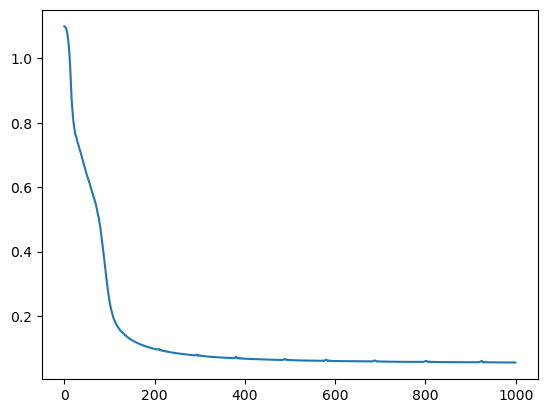

In [14]:
hidden_layers=np.array([20,10])
mlp = MLP(4,3,hidden_layers,0.01,'adam')
loss_history=mlp.fit(X_train,y_train,1000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

in softmax, Z is a vector

Below is my history to optimize and adjust paramters for this algorithm
First, my learning rate==0.05, epoch == 10000, hidden_layer_size==[5,3]


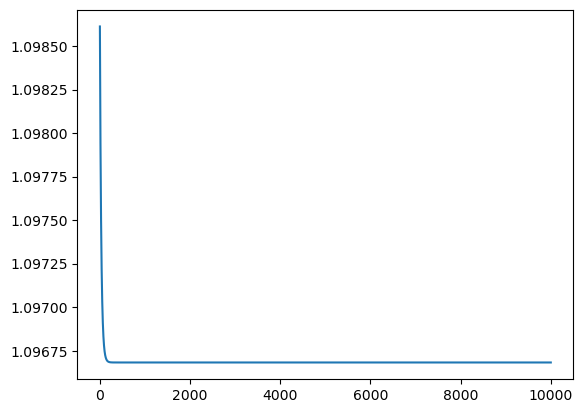

In [23]:
hidden_layers=np.array([2,3])
mlp = MLP(4,3,hidden_layers,0.05,'gradient_descent')
loss_history=mlp.fit(X_train,y_train,10000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    #print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

Here we can see the loss function actually does not converge to a small number during this period. Intuitively, we should increase learning rate to accelerate the speed of loss descending

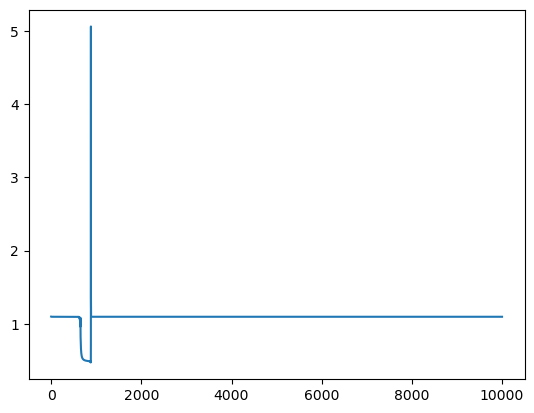

In [26]:
hidden_layers=np.array([2,3])
mlp = MLP(4,3,hidden_layers,0.5,'gradient_descent')
loss_history=mlp.fit(X_train,y_train,10000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    #print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

Adding learning rate did not make a difference. 
We should increase complexity of hidden layers

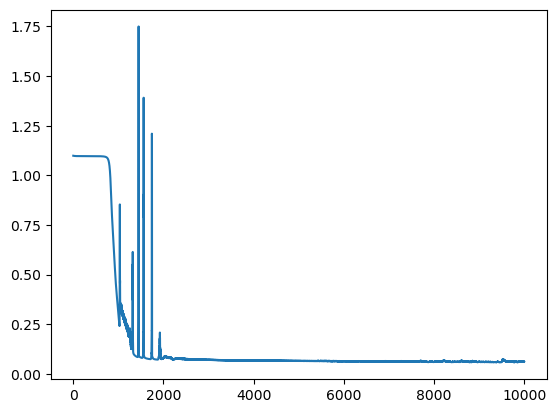

In [28]:
hidden_layers=np.array([20,10])
mlp = MLP(4,3,hidden_layers,0.05,'gradient_descent')
loss_history=mlp.fit(X_train,y_train,10000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    #print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

Although loss oscillate, it converges finally.
This oscillation suggests that we have a relatively large learning rate. 
This is counterintuitive because we believe the learning rate is too large that it could not converge. But after we adjust hidden layer size, we find that the learning rate is large. 
We should use a smaller learning rate.

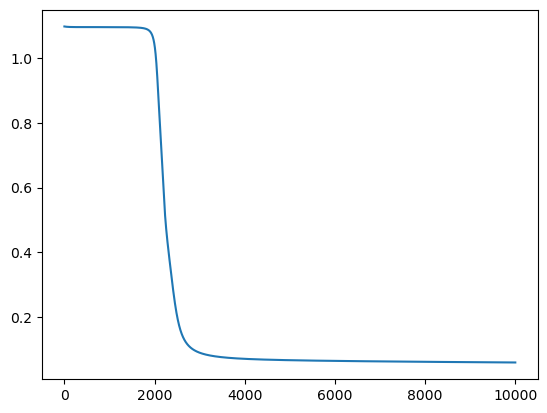

In [30]:
hidden_layers=np.array([20,10])
mlp = MLP(4,3,hidden_layers,0.02,'gradient_descent')
loss_history=mlp.fit(X_train,y_train,10000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    #print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

The loss plot seems smoother than before. But there is always a plateau at early 2000 epochs. 
We use gradient descent to find the gradient way to decrease the function, but there actually some relative plane space where gradient is very small, this way we need a very long iteration to get away. And this is why loss could not converge at first. When we add size of hidden layers, we add approaches to get away.
To solve this, we can replace gradient descent with adam.
Adam optimizer is self-adaptive backward propagation algorithm. Self-adaptive means that it can adjust learning_rate autonomously.

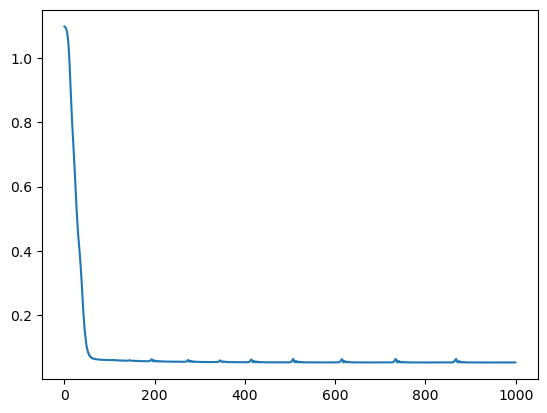

In [32]:
hidden_layers=np.array([20,10])
mlp = MLP(4,3,hidden_layers,0.02,'adam')
loss_history=mlp.fit(X_train,y_train,1000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    #print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

Compared to 'gradient descent', 'adam' speed up this process. 
(gradient descent uses about 2500 epochs while adam uses 100 epochs)
But there some impulse in the loss diagram. This suggests that learning rate is too large.

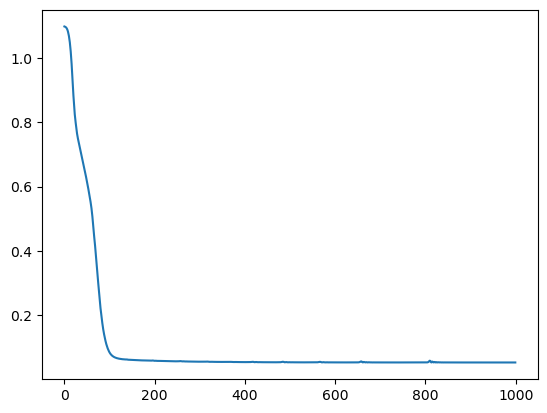

In [33]:
hidden_layers=np.array([20,10])
mlp = MLP(4,3,hidden_layers,0.01,'adam')
loss_history=mlp.fit(X_train,y_train,1000)
plt.plot(loss_history)


for i in range(len(X_test)):
    y_pred_i = mlp.predict(X_test[i])
    #print(f'y_predict {y_pred_i}, y_true: {y_test[i]}')

plt.show()

Much better